In [1]:
%load_ext autoreload
%autoreload 2

# 1. Extract feature descriptors for the 42 templates

In [4]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_748402/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [38]:
from hydra.utils import instantiate
# define the cnos model
cfg_segmentor = cfg.model.segmentor_model
if "fast_sam" in cfg_segmentor._target_:
    logging.info("Using FastSAM, ignore stability_score_thresh!")
else:
    cfg.model.segmentor_model.stability_score_thresh = 0.97 # for sam
cfg.model.descriptor_model.model.num_block = 19

model = instantiate(cfg.model).to("cuda")

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [39]:
model.descriptor_model.model.num_block

19

In [40]:
import glob
import torch
import numpy as np
import logging
from PIL import Image
from src.utils.bbox_utils import CropResizePad
# can also put the tranform for the image before going via Dino - but actually I tested that and it is actually the same

def template_feature_extraction(template_dir):
    template_paths = glob.glob(f"{template_dir}/*.png")
    boxes, templates = [], []
    for path in template_paths:
        image = Image.open(path)
        boxes.append(image.getbbox())
        image = torch.from_numpy(np.array(image.convert("RGB")) / 255).float() # convert templates in format of Image to np then devide them by 255
        templates.append(image)
        
    templates = torch.stack(templates).permute(0, 3, 1, 2) # now qw have a stack of 42,3,480*640
    boxes = torch.tensor(np.array(boxes))

    processing_config = OmegaConf.create(
        {
            "image_size": 224,
        }
    )
    proposal_processor = CropResizePad(processing_config.image_size)
    templates = proposal_processor(images=templates, boxes=boxes).cuda() # here resize the templates to size of 42,3,224,224 I assume
    # save_image(templates, f"{template_dir}/cnos_results/templates.png", nrow=7) # here just put all templates in 1 image and save it
    ref_features = model.descriptor_model.compute_features(
                    templates, token_name="x_norm_clstoken"
                ) # extract features for the 42 templates - obtain shape as 42,1024
    print(f"Ref feats: {ref_features.shape}")
    return ref_features

In [41]:
template_dir = "cnos_analysis/real_images_templates/icbin/obj_000001"
ref_features = template_feature_extraction(template_dir)

Ref feats: torch.Size([42, 1024])


In [42]:
synthetic_template_dir = "cnos_analysis/real_images_templates/icbin/train_pbr_templates/obj_000001"
synthetic_ref_features = template_feature_extraction(synthetic_template_dir)

Ref feats: torch.Size([42, 1024])


# 2. Extract features from crop and compare with templates

In [43]:
import torchvision.transforms as T
import torch.nn.functional as F

def crop_feature_extraction(crop_rgb, cnos_model):
    # crop_rgb: numpy array
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    normalized_crop_rgb = rgb_normalize(crop_rgb).float()

    # Scale image to 224
    target_max = 224
    scale_factor = target_max / torch.max(torch.tensor(normalized_crop_rgb.shape)) # 224/max of x1,y1,x2,y2
    scaled_crop_rgb = F.interpolate(normalized_crop_rgb.unsqueeze(0), scale_factor=scale_factor.item())[0] # Shape [3, 176, 224])
    
    # Padding 0 to 3,224,224
    original_h, original_w = scaled_crop_rgb.shape[1:]
    original_ratio = original_w / original_h
    target_h, target_w = 224, 224
    target_ratio  = target_w/target_h 
    if  target_ratio != original_ratio: 
        padding_top = max((target_h - original_h) // 2, 0)
        padding_bottom = target_h - original_h - padding_top
        padding_left = max((target_w - original_w) // 2, 0)
        padding_right = target_w - original_w - padding_left
        scaled_padded_crop_rgb = F.pad(
        scaled_crop_rgb, (padding_left, padding_right, padding_top, padding_bottom)
        )
    else:
        scaled_padded_crop_rgb = scaled_crop_rgb
    scaled_padded_crop_rgb = scaled_padded_crop_rgb.unsqueeze(0) # unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_crop_rgb.shape", scaled_padded_crop_rgb.shape) # Should be 1,3,224,224 - if not then do line 122 in src/utils/bbox_utils.py
    
    feature_decriptors = cnos_model.descriptor_model.forward_by_chunk(scaled_padded_crop_rgb.to("cuda"))
    # Forward_by_chunk cos we already process all the prosals that we get the processed_rgbs = scaled_padded_crop_rgb from previous steps already
    print("feature_decriptors.shape", feature_decriptors.shape)

    # Display the image - 10* see lb the crop is normalized same way as the templates- ready to compare the similarity now
    plt.imshow(scaled_padded_crop_rgb[0].permute(1,2,0))
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()
    return feature_decriptors

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from src.model.loss import PairwiseSimilarity, Similarity
from torchvision.io import read_image
metric = Similarity() # cnos  uses PairwiseSimilariy - what is the difference between Similarity and Pairwise Similarity ?

def calculate_similarity(crop_rgb, feature_decriptors, ref_features, metric, synthetic=False):
    # get scores per proposal
    scores = metric(feature_decriptors[:, None, :], ref_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
    score_per_detection, similar_template_indices = torch.topk(scores, k=5, dim=-1) # get top 5 most similar templates
    # get the final confidence score
    score_per_detection = torch.mean(
        score_per_detection, dim=-1
    ) 
    # Check the confidence scores for the similar templates
    similar_scores = scores[:, similar_template_indices[0].to("cpu")]

    similar_templates = []
    for i in range(len(similar_template_indices[0])):
        if synthetic:
            img = read_image(f"cnos_analysis/real_images_templates/icbin/train_pbr_templates/obj_000001_original/{(similar_template_indices[0][i]):06d}.png")            
        else:
            img = read_image(f"cnos_analysis/real_images_templates/icbin/obj_000001_original/{(similar_template_indices[0][i]):06d}.png")        
        similar_templates.append(img)
    tempplate_images = torch.stack(similar_templates)

    # Display the crop
    plt.imshow(crop_rgb)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    print("top 5 confidence scores", similar_scores)
    print("final average confidence score", score_per_detection)

    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, len(tempplate_images)+1):
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(tempplate_images[i-1].permute(1,2,0))
    plt.show()
    return

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])
feature_decriptors.shape torch.Size([1, 1024])


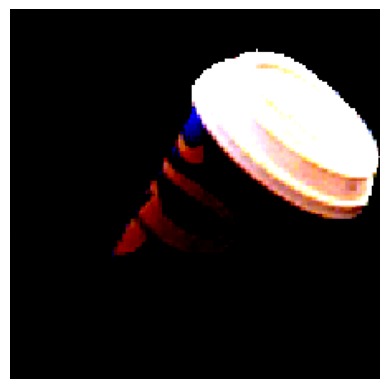

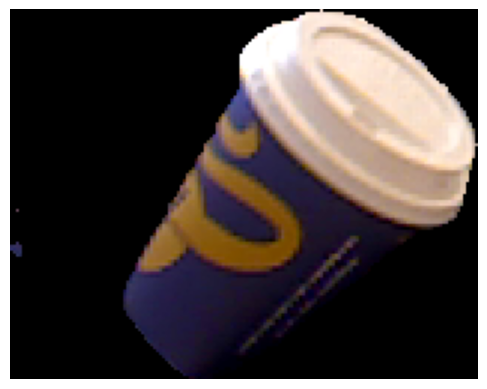

top 5 confidence scores tensor([[0.8592, 0.8574, 0.8551, 0.8506, 0.8506]], device='cuda:0')
final average confidence score tensor([0.8546], device='cuda:0')


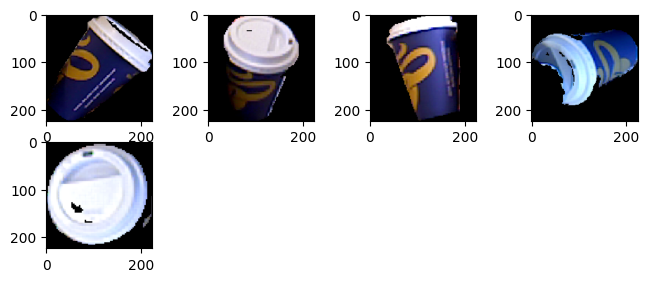

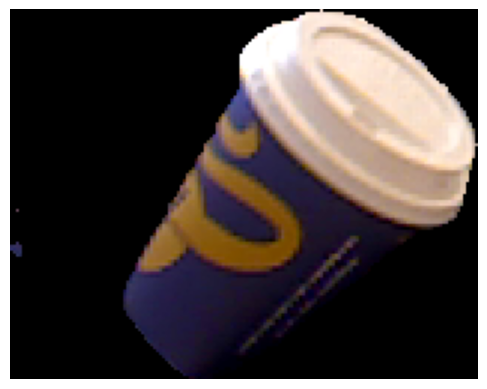

top 5 confidence scores tensor([[0.8768, 0.8760, 0.8751, 0.8696, 0.8629]], device='cuda:0')
final average confidence score tensor([0.8721], device='cuda:0')


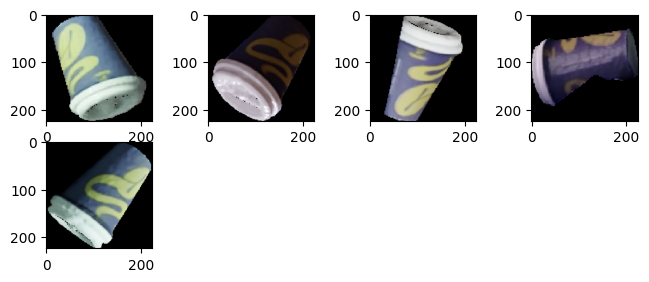

In [45]:
# normal crop
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
normal_features = crop_feature_extraction(crop_rgb, model)
calculate_similarity(crop_rgb, normal_features, ref_features, metric, synthetic=False)
calculate_similarity(crop_rgb, normal_features, synthetic_ref_features, metric, synthetic=True)


In [46]:
from scipy.ndimage import zoom
def zoom_in(image, scale):
    return zoom(image, (scale, scale, 1))[image.shape[0]:,image.shape[1]:,:]

def zoom_out(image, scale):
    zoomed_out_image =  zoom(image, (1/scale, 1/scale, 1))
    print(np.min(zoomed_out_image))
    background = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
    background[image.shape[0]//2:zoomed_out_image.shape[0]+image.shape[0]//2, image.shape[0]//2:zoomed_out_image.shape[1]
        +image.shape[0]//2,:] = zoomed_out_image
    print(np.min(background))
    # Clip values to be in the valid range [0, 255] and convert back to uint8
    background = background.astype("uint8")
    return background

crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
zoom_scale = 3  # Zoom in by a factor of 2
crop_rgb_zoomed_in = zoom_in(crop_rgb, zoom_scale)
crop_rgb_zoomed_out = zoom_out(crop_rgb, scale=2)


0
0.0


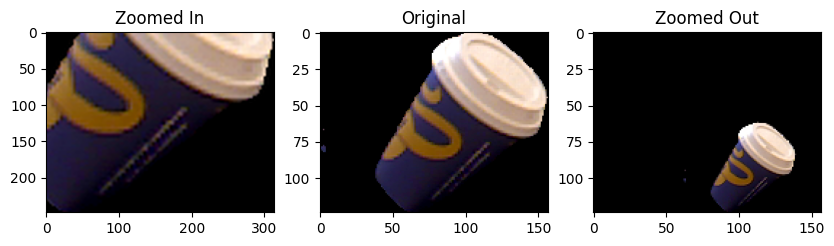

In [47]:
# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title(f"Zoomed In")
plt.imshow(crop_rgb_zoomed_in)

plt.subplot(1, 3, 2)
plt.title(f"Original")
plt.imshow(crop_rgb)

plt.subplot(1, 3, 3)
plt.title(f"Zoomed Out")
plt.imshow(crop_rgb_zoomed_out)

## 2.1 Zoomed-in crop

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])
feature_decriptors.shape torch.Size([1, 1024])


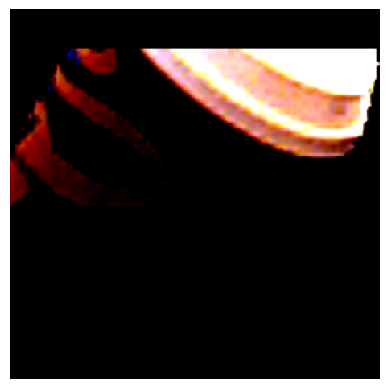

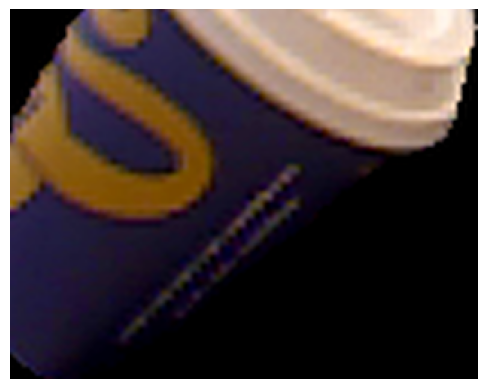

top 5 confidence scores tensor([[0.8452, 0.8406, 0.8391, 0.8382, 0.8362]], device='cuda:0')
final average confidence score tensor([0.8399], device='cuda:0')


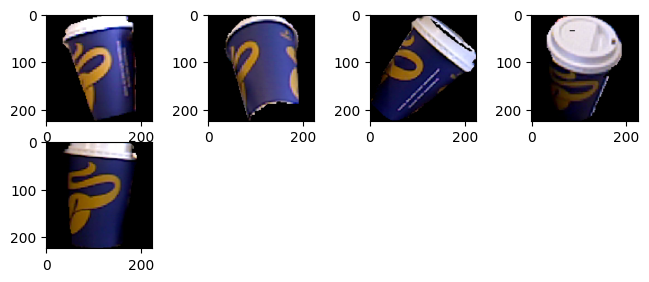

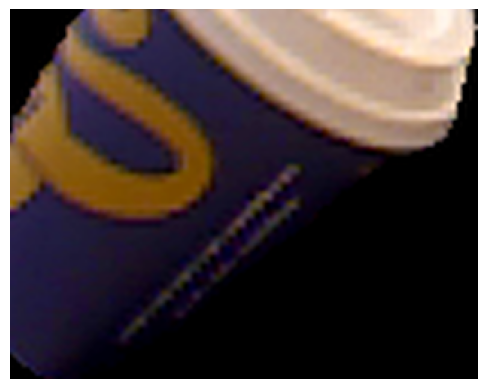

top 5 confidence scores tensor([[0.8633, 0.8595, 0.8567, 0.8547, 0.8516]], device='cuda:0')
final average confidence score tensor([0.8572], device='cuda:0')


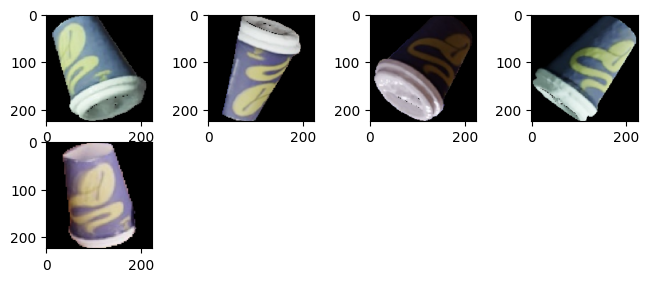

Cosine similarity to the original crop tensor([[0.9649]], device='cuda:0')


In [48]:
zoom_in_features = crop_feature_extraction(crop_rgb_zoomed_in, model)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, ref_features, metric, synthetic=False)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, synthetic_ref_features, metric, synthetic=True)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
zoom_in_scores = metric(normal_features[:, None, :], zoom_in_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
print("Cosine similarity to the original crop", zoom_in_scores)

## 2.2 Zoomed-out crop

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])
feature_decriptors.shape torch.Size([1, 1024])


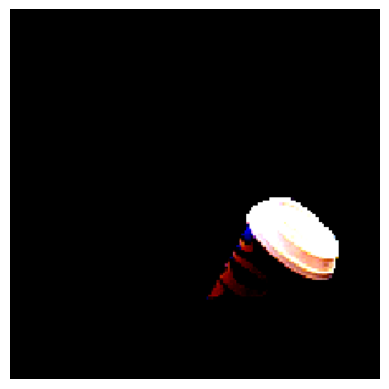

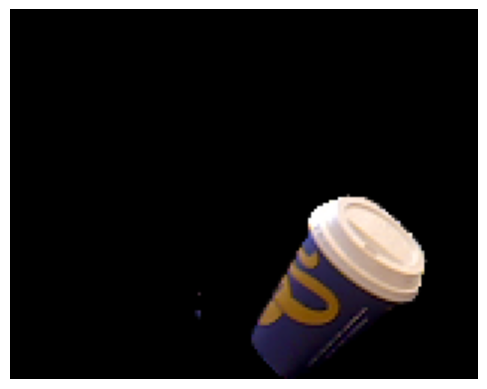

top 5 confidence scores tensor([[0.8404, 0.8396, 0.8350, 0.8338, 0.8332]], device='cuda:0')
final average confidence score tensor([0.8364], device='cuda:0')


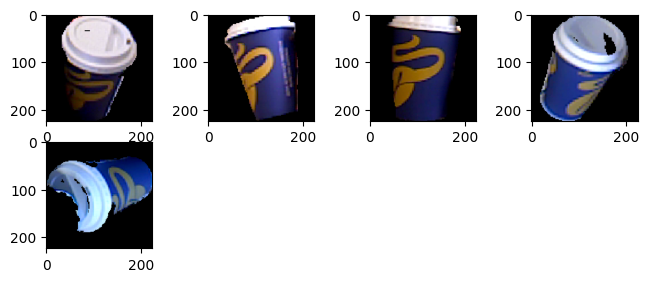

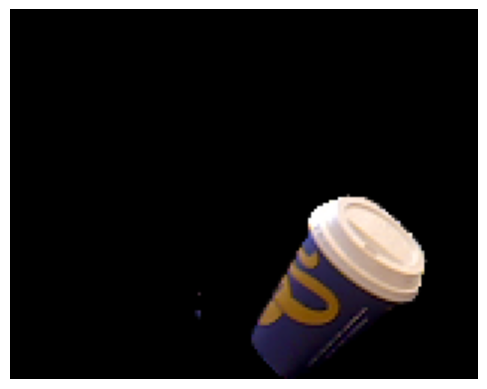

top 5 confidence scores tensor([[0.8539, 0.8425, 0.8361, 0.8352, 0.8331]], device='cuda:0')
final average confidence score tensor([0.8402], device='cuda:0')


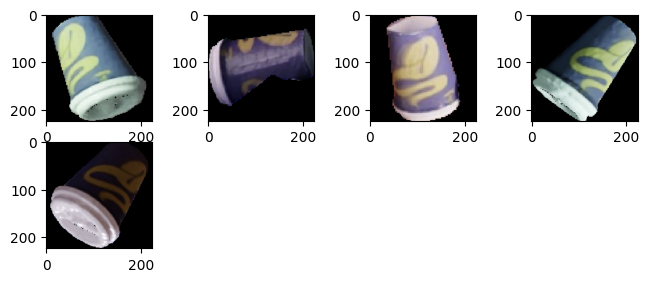

tensor([[0.9585]], device='cuda:0')

In [49]:
zoom_out_features = crop_feature_extraction(crop_rgb_zoomed_out, model)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, ref_features, metric, synthetic=False)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, synthetic_ref_features, metric, synthetic=True)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
zoom_in_scores = metric(normal_features[:, None, :], zoom_out_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
zoom_in_scores

## 2.3 In-plane rotated crop

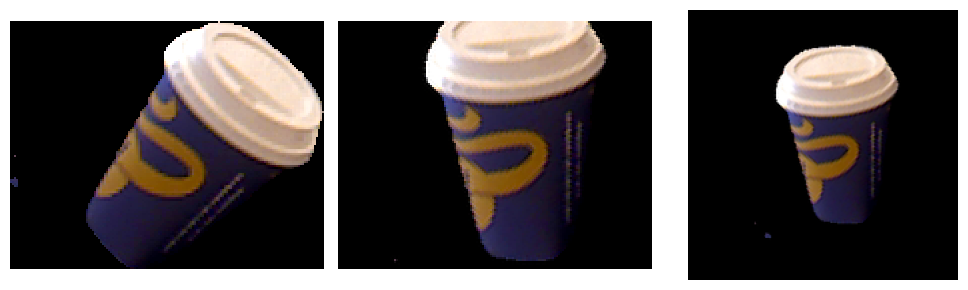

In [50]:
from scipy import ndimage, datasets
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 3))
ax1, ax2, ax3 = fig.subplots(1, 3)
img = crop_rgb
img_45 = ndimage.rotate(img, 45, reshape=False)
full_img_45 = ndimage.rotate(img, 45, reshape=True)
ax1.imshow(img, cmap='gray')
ax1.set_axis_off()
ax2.imshow(img_45, cmap='gray')
ax2.set_axis_off()
ax3.imshow(full_img_45, cmap='gray')
ax3.set_axis_off()
fig.set_layout_engine('tight')
plt.show()

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])
feature_decriptors.shape torch.Size([1, 1024])


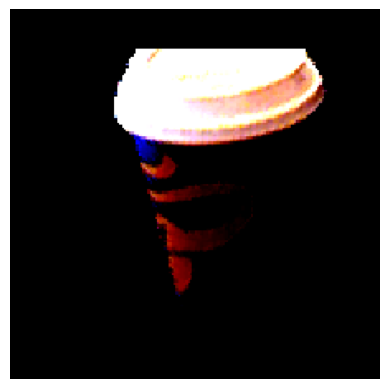

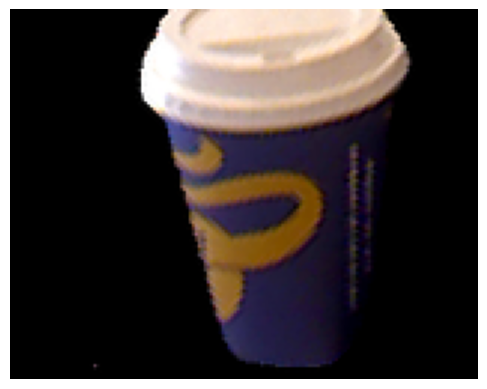

top 5 confidence scores tensor([[0.8440, 0.8439, 0.8395, 0.8384, 0.8378]], device='cuda:0')
final average confidence score tensor([0.8407], device='cuda:0')


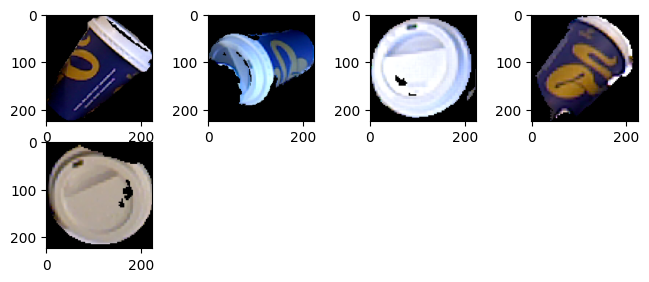

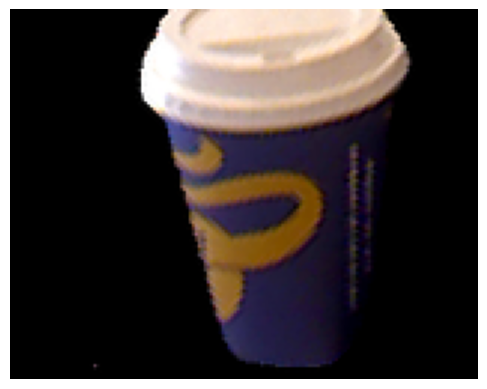

top 5 confidence scores tensor([[0.8617, 0.8597, 0.8574, 0.8552, 0.8544]], device='cuda:0')
final average confidence score tensor([0.8577], device='cuda:0')


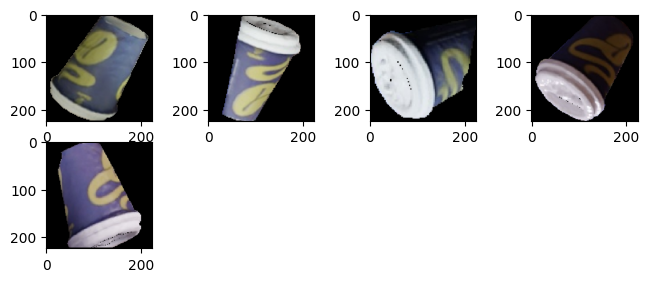

tensor([[0.9523]], device='cuda:0')

In [51]:
rotated_45_features = crop_feature_extraction(img_45, model)
calculate_similarity(img_45, rotated_45_features, ref_features, metric, synthetic=False)
calculate_similarity(img_45, rotated_45_features, synthetic_ref_features, metric, synthetic=True)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
rotated_45_scores = metric(normal_features[:, None, :], rotated_45_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
rotated_45_scores

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])
feature_decriptors.shape torch.Size([1, 1024])


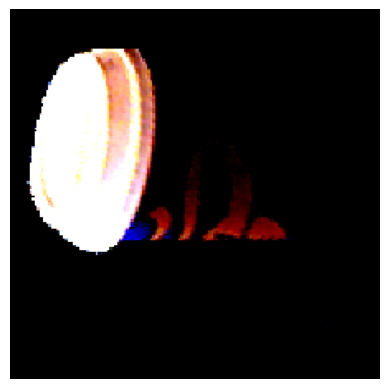

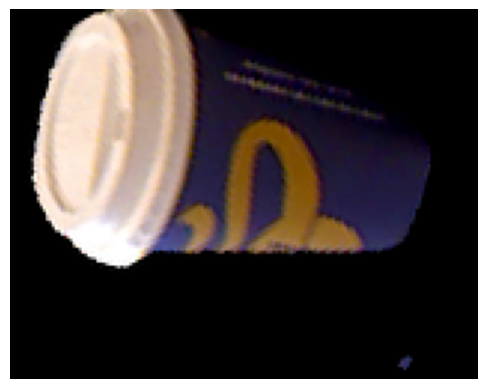

top 5 confidence scores tensor([[0.8530, 0.8487, 0.8436, 0.8407, 0.8393]], device='cuda:0')
final average confidence score tensor([0.8450], device='cuda:0')


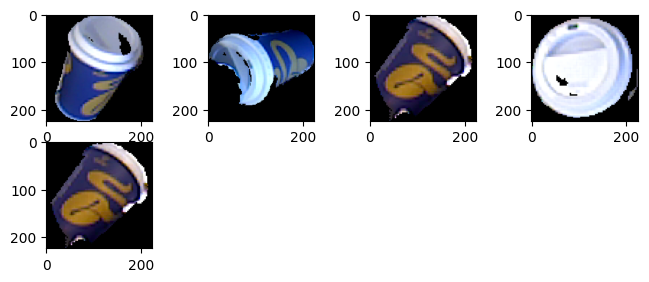

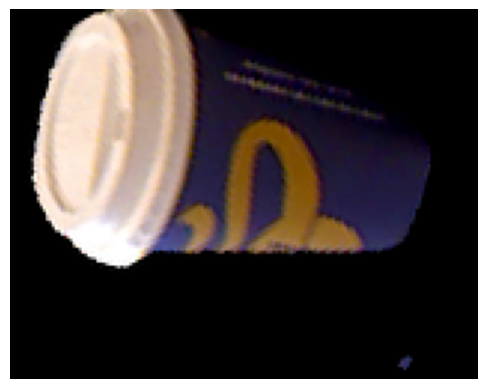

top 5 confidence scores tensor([[0.8731, 0.8675, 0.8647, 0.8644, 0.8620]], device='cuda:0')
final average confidence score tensor([0.8663], device='cuda:0')


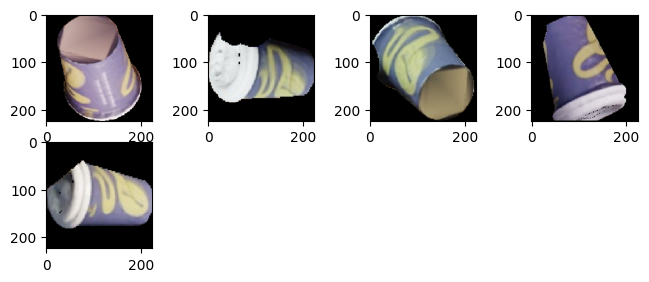

tensor([[0.9109]], device='cuda:0')

In [52]:
img_120 = ndimage.rotate(img, 120, reshape=False)
rotated_120_features = crop_feature_extraction(img_120, model)
calculate_similarity(img_120, rotated_120_features, ref_features, metric, synthetic=False)
calculate_similarity(img_120, rotated_120_features, synthetic_ref_features, metric, synthetic=True)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
rotated_120_scores = metric(normal_features[:, None, :], rotated_120_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
rotated_120_scores

### Conclusion: Rotated images will not be the same according to consine similarity

## 2.4 Occluded crop

In [53]:
# occluded_crop = crop_rgb[124//2:,:157//2,:]
occluded_crop = crop_rgb[:124//2,157//2:,:]

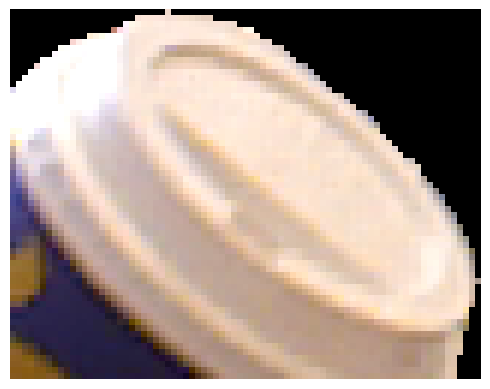

In [54]:
import matplotlib.pyplot as plt
plt.imshow(occluded_crop)
plt.axis("off")
plt.show()

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])
feature_decriptors.shape torch.Size([1, 1024])


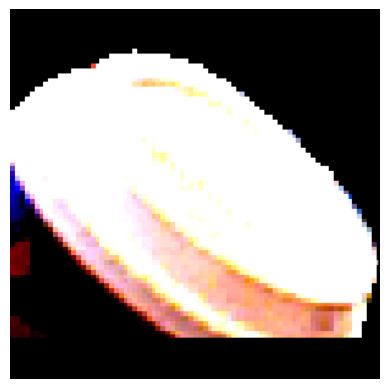

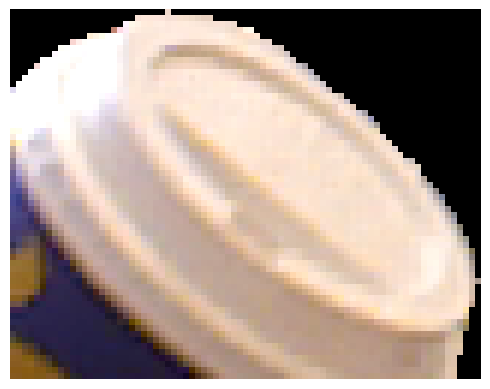

top 5 confidence scores tensor([[0.8749, 0.8734, 0.8530, 0.8519, 0.8519]], device='cuda:0')
final average confidence score tensor([0.8610], device='cuda:0')


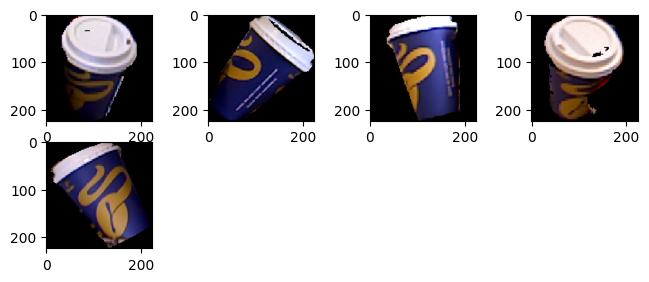

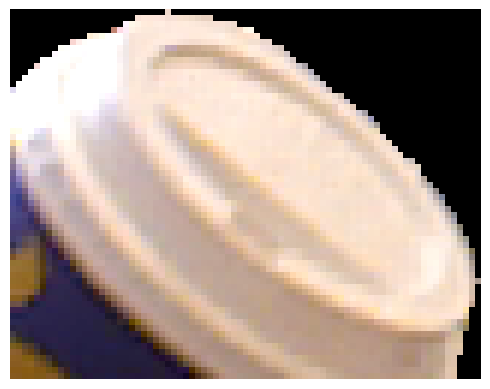

top 5 confidence scores tensor([[0.8836, 0.8813, 0.8667, 0.8666, 0.8653]], device='cuda:0')
final average confidence score tensor([0.8727], device='cuda:0')


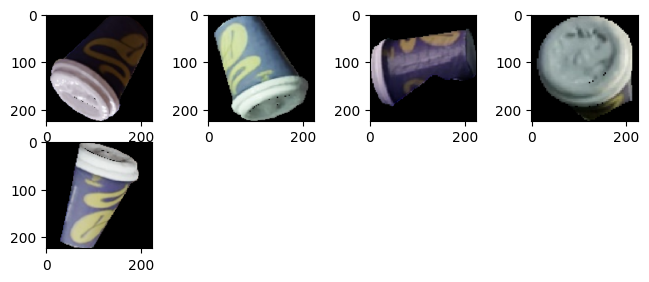

tensor([[0.9416]], device='cuda:0')

In [55]:
occluded_features = crop_feature_extraction(occluded_crop, model)
# Real templates
calculate_similarity(occluded_crop, occluded_features, ref_features, metric, synthetic=False)
# Synthetic templates
calculate_similarity(occluded_crop, occluded_features, synthetic_ref_features, metric, synthetic=True)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
occluded_scores = metric(normal_features[:, None, :], occluded_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
occluded_scores

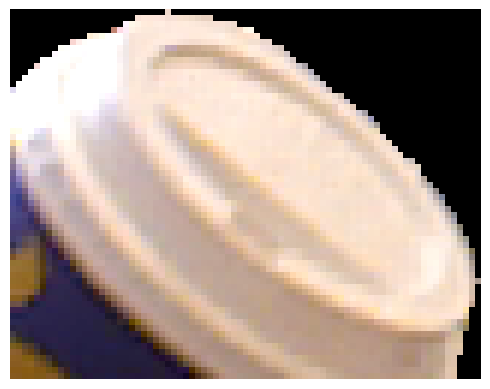

top 5 confidence scores tensor([[0.8836, 0.8813, 0.8667, 0.8666, 0.8653]], device='cuda:0')
final average confidence score tensor([0.8727], device='cuda:0')


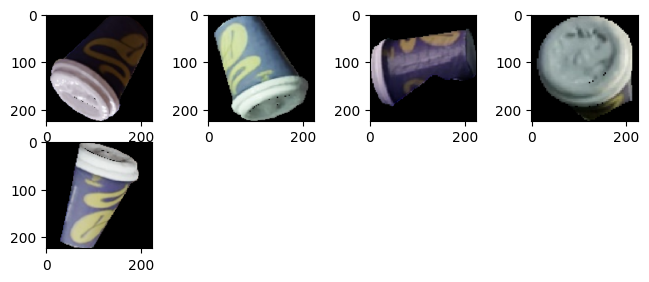

In [56]:
# Synthetic templates
calculate_similarity(occluded_crop, occluded_features, synthetic_ref_features, metric, synthetic=True)

# 3. Try dense feature with mid-layer feature map from dino

In [57]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.to("cuda:0")

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [58]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import math
from functools import partial
class SmallDinov2(pl.LightningModule):
    def __init__(
        self,
        dinov2_vitl14=None,
        num_block=50,
    ):
        super().__init__()
        # Load the pre-trained model only if it's not provided
        if dinov2_vitl14 is None:
            dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
        # Extract the layers
        
        self.patch_embed = dinov2_vitl14.patch_embed
        self.blocks = nn.ModuleList(dinov2_vitl14.blocks[:num_block])
        self.norm = dinov2_vitl14.norm
        self.dinov2_vitl14 = dinov2_vitl14
        self.head = dinov2_vitl14.head

    @torch.no_grad()
    def forward_features(self, x, masks=None):
        x = self.dinov2_vitl14.prepare_tokens_with_masks(x, masks)

        for blk in self.blocks:
            x = blk(x)

        x_norm = self.norm(x)
        return {
            "x_norm_clstoken": x_norm[:, 0],
        }
    @torch.no_grad()
    def forward(self, *args, **kwargs):
        ret = self.forward_features(*args, **kwargs)
        return self.head(ret["x_norm_clstoken"])

# Create the model and move it to the GPU
small_dinov2 = SmallDinov2().to("cuda:0")

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [59]:
# Example input tensor, ensure it is on the same device as the model
input_tensor = torch.randn(1, 3, 224, 224).to("cuda:0")

## Check the model if the 2 are the same, if the 2 outputs are same - here they are same
with torch.no_grad():
    small_out = small_dinov2(input_tensor)
with torch.no_grad():
    dino_out = dinov2_vitl14(input_tensor)
dino_out - small_out

tensor([[ 2.3842e-07,  2.2352e-07, -1.1921e-06,  ..., -1.4305e-06,
          9.5367e-07,  5.9605e-07]], device='cuda:0')

# 4. Use BlenderProc to render real templates from CAD models
Then test on crops as well as on whole image to see if the results as well as confidence scores are improved/affected